# Lecture 2: Introduction to the Maximum Likelihood Estimation method

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2023/24 data science class at the Rudjer Boskovic Institute, and it is available from [github](https://github.com/ivezic/IRB2023/blob/main/notebooks/IRBclass2.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards, and many many others.

<a id='toc'></a>

## This notebook includes:

[Introduction: what likelihood is and what it is good for?](#ML1)

[Simple examples of MLE: one-dimensional Gaussian](#ML2)

[MLE in action: fitting a parametrized model with heteroscedastic gaussian errors on y axis](#ML3)

[Goodness of fit](#chi2) 

[Cost functions and penalized likelihood](#ML4)

[Non-gaussian likelihood: binomial distribution (coin flip problem)](#ML5)

[Conceptual difficulties with the MLE (example: "waiting for a bus" problem)](#ML6)

[What if we cannot write down the likelihood function?](#ML7)

## Introduction: what likelihood is and what it is good for? <a id='ML1'></a>
[Go to top](#toc)

### The Core Idea Behind Maximum Likelihood Estimators

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters).

Then Maximum Likelihood Estimation method tells us to think of the likelihood as a ***function of the unknown model parameters***, and ***find those that maximize the value of $L$***. Those will be our Maximum Likelihood Estimators for for the true values of the model.

Simple as that!

#### Example: 
If I draw values from a Gaussian $N(\mu, \sigma)$, e.g. measuring quantity $\mu$
with uncertainty $\sigma$ (somewhat erroneously a.k.a. “error bar”), 

then the probability that the measured value will be between $x$ and $x+dx$ is 

$$ p(x) = N(\mu,\sigma) * dx $$
where
      $$ N(\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$


For a sample of $N$ data points, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma$, the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

**An important assumption** that we made here is that random noise for different 
data points is independent (if it's not, we need to use methods such as Gaussian
process modeling). This assumption allowed us to simply multiply the likelihoods
for individual data points to obtain the likelihood of the whole dataset. 


Let's now see some numerical illustrations...
 

In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)
%matplotlib inline  

In [2]:
### Let's draw a homoscedastic sample of {x_i} from a Gaussian and see what happens with L
# first generate a sample of N points drawn from N(mu,sigma):
sampleSize=3
mu = 1.0
sigma = 0.2 
sample = norm(mu, sigma).rvs(sampleSize) 
print('our data points:', sample)

our data points: [1.09934283 0.97234714 1.12953771]


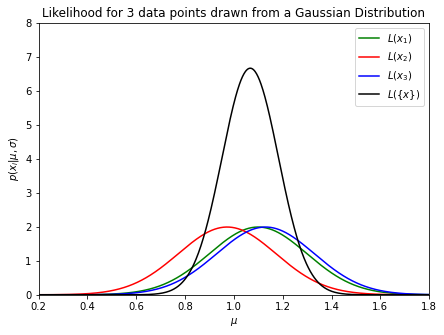

In [3]:
### Let's draw a homoscedastic sample of {x_i} from a Gaussian and see 
### what happens with L 
# now compute likelihoods for each point using true mu 
muGrid = np.linspace(0,2,1000)
L1 = norm(sample[0], sigma).pdf(muGrid) 
L2 = norm(sample[1], sigma).pdf(muGrid) 
L3 = norm(sample[2], sigma).pdf(muGrid) 
L = L1 * L2 * L3
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Likelihood for 3 data points drawn from a Gaussian Distribution')
plt.legend()
plt.show() 

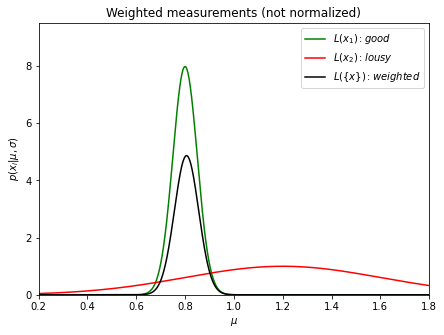

In [4]:
### What happens when we have one precise and one lousy measurement? 
L1 = norm(0.8, 0.05).pdf(muGrid)    
L2 = norm(1.2, 0.40).pdf(muGrid)     ## this is the lousy one: sigma = 0.4 >> 0.05
L = L1 * L2 
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1): good$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2): lousy$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\}): weighted$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 9.5)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Weighted measurements (not normalized)')
plt.legend()
plt.show() 
 

**If either of the two likelihoods (or one of the likelihood and prior pair) is 
the Dirac's $\delta$ function ("zero width"), the posterior is the same delta function.**
 

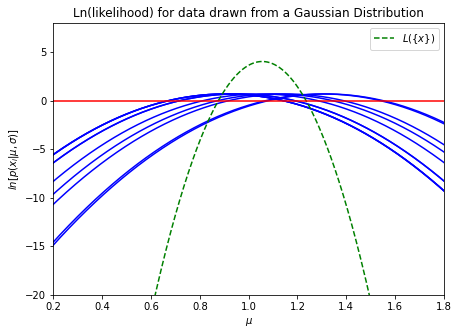

In [5]:
### Same as above, but with 10 points and on log scale
sampleSize=10
sampleBig = norm(mu, sigma).rvs(sampleSize) 
lnL = 0*muGrid
# compute and plot
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(0,sampleSize):
    lnLone = np.log(norm(sampleBig[i], sigma).pdf(muGrid)) 
    plt.plot(muGrid, lnLone, ls='-', c='blue')
    lnL += lnLone 
plt.plot(muGrid, lnL, ls='--', c='green', label=r'$L(\{x\})$')

plt.axhline(y=0.0, color='red', linestyle='-')
plt.xlim(0.2, 1.8)
plt.ylim(-20.0, 8.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$ln[p(x_i|\mu,\sigma)]$')
plt.title('Ln(likelihood) for data drawn from a Gaussian Distribution')
plt.legend()
plt.show() 

#### Important Notes: 
- likelihood values can be very small - the use of ln() (natural logarithm; giving log-likelihood) helps with displaying large dynamic range
- the use of ln()  is even more important when likelihoods for individual data points are multiplied: the product of likelihoods becomes a sum of ln(likelihood)
- the sample likelihood is not a true probability distribution - its integral is not 1! 
- the more data we add, the more "peaked" is the likelihood $L(\{x\})$ around
  the true value of $\mu$ (=1.0); this is the famous $1/\sqrt{N}$ behavior and we'll return to this point



#### Example: 
If I draw values from a Gaussian $N(\mu, \sigma)$, e.g. measuring quantity mu
with uncertainty $\sigma$ (somewhat erroneously a.k.a. “error bar”), 

then the probability that the measured value will be between $x$ and $x+dx$ is 

$$ p(x) = N(\mu,\sigma) * dx $$
where
      $$ N(\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$



#### What's so special about Gaussian (normal) distribution? 
- a Gaussian comes from the Central Limit Theorem (the mean of samples drawn from an almost 
    arbitrary distribution will follow a Gaussian distribution) 
- Gaussians have nice properties (convolution, Fourier transform, independence of mean and variance)
- Poisson distribution morphs into a Gaussian distribution for large $\mu$

** but likelihood function doesn’t have to be a gaussian!!! ** (it could be, e.g., exponential, 
uniform, poisson, or double gaussian distribution)

  

### What likelihood is and what it is good for? 

In everyday life, "likelihood" is often used as a synonym for "probability.” 

In statistics, **probability is used before data are available** to describe possible future 
outcomes given fixed model parameters (“a function of x with theta fixed”, like above), 
while **likelihood is used after data are available** to describe a function of model parameters 
for a given outcome (“a function of theta with x fixed”). ** But it's the same function (as above)!**

The two main reasons we are talking about the likelihood function

- Maximum Likelihood Estimation (MLE) is one of the most important methods in statistics
- The likelihood function is a crucial ingredient in the Bayesian framework (note for later: in case of flat priors, MLE produces numerically identical result as the Bayesian Maximum A Posteriori, MAP, estimate)

### Maximum Likelihood Estimation (MLE) is one of the most important methods in statistics 

**MLE:** Assume that the likelihood function is given by
$$L(\mu,\sigma) \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

A practical example of the above would be weight measurements for the IRB employees,
with measurement uncertainties negligible compared to the intrinsic distribution width
$\sigma$ (say, uncertainties of $\sim0.01$ kg vs $\sigma \sim$10 kg).



We can make use of   
$$\prod_{i=1}^n A_i \exp(-B_i) = (A_iA_{i+1}\ldots A_n) \exp[-(B_i+B_{i+1}+\ldots+B_n)]$$
and obtain
$$lnL(\mu,\sigma) \equiv ln[p(\{x_i\}|\mu,\sigma)] = const. - \frac{1}{2}\sum_{i=1}^N \frac{(x_i-\mu)^2}{\sigma^2}.$$


Side note: for multidimensional distributions, as we will see later in the course, the uncertainties come in the form of a covariance matrix where there uncertainties can be correlated. This still assumes Gaussianity

$$ p(D\; | \;  \pmb \theta\;) =  \prod_{k=1}^{n} \; \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$$

where $\Sigma$ is the covariance matrix and $d$ is the dimensionality.



### An important side note
In case of gaussian likelihood, maximizing $lnL$ is equivalent to 
minimizing "chi-square"
$$\chi2 = \sum_{i=1}^N \frac{(x_i-\mu)^2}{\sigma^2}.$$ 
In other words,
$$ L \propto exp(-\frac{\chi^2}{2}).$$

## Simple examples of MLE: one-dimensional Gaussian<a id='ML2'></a>
[Go to top](#toc)

#### Maximum Likelihood Estimation (MLE) applied to a Heteroscedastic Gaussian

For example, assume $N$ measurements, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma_i$. The likelihood of one measurement is 

$$p(x_i|\mu,\sigma_i) = \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$


and therefore the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma_i^2}\right).$$

An astronomical example of the above would be measurements of the mass
of an object, $\mu$ (that is, there is no intrinsic $\sigma$, only measurement
errors $\sigma_i$).

The more convenient log-likelihood is 
$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

Taking the derivative:
$$\frac{d\;{\rm lnL}(\mu)}{d\mu}\Biggr\rvert_{\mu_0} = \sum_{i=1}^N \frac{(x_i - \mu_o)}{\sigma_i^2} = 0,$$
then simplifying:

$$\sum_{i=1}^N \frac{x_i}{\sigma_i^2} = \sum_{i=1}^N \frac{\mu_o}{\sigma_i^2},$$

yields a MLE solution of 
$$\mu_0 = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty (from the second derivative)
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

 
In case of homoscedastic uncertainties, we get the familiar expression
$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$


** Know your likelihood! **

The result for $\sigma_{\mu}$ has been derived by expanding $\ln L$ in a Taylor 
series and retaining terms up to second order (essentially, the surface of $\ln L$ 
is approximated by a parabola, or an ellipsoidal surface in multidimensional cases, 
around its maximum). If this expansion is exact (as is the case for a Gaussian error 
distribution), then we've completely captured the error information (see illustration
below). 

In general, this is not the case and the likelihood surface can significantly deviate 
from a smooth elliptical surface. Furthermore, it often happens in practice that the 
likelihood surface is multimodal. It is always a good idea to visualize the likelihood 
surface when in doubt.
 

### Properties of ML Estimators

Assuming the data truly are drawn from the model, ML estimators have the following useful properties:

* **They are consistent estimators**; that is, they can be proven to converge to the true parameter value as the number of data points increases.
* **They are asymptotically normal estimators**. The distribution of the parameter estimate, as the number of data points increases to infinity, approaches a normal distribution, centered at the MLE, with a certain spread. This spread can often be easily calculated and used as a confidence band around the estimate, as discussed below (see eq. 4.7).
* **They asymptotically achieve the theoretical minimum possible variance, called the Cramér–Rao bound**. In other words, they achieve the best possible uncertainty given the data at hand; that is, no other estimator can do better in terms of efficiently using each data point to reduce the total error of the estimate (see eq. 3.33 in the textbook).

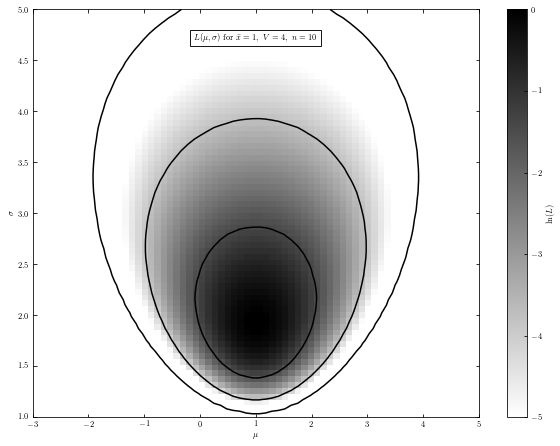

In [6]:
"""
Log-likelihood for Gaussian Distribution
----------------------------------------
Figure5.4
An illustration of the logarithm of the posterior probability density
function for :math:`\mu` and :math:`\sigma`, :math:`L_p(\mu,\sigma)`
(see eq. 5.58) for data drawn from a Gaussian distribution and N = 10, x = 1,
and V = 4. The maximum of :math:`L_p` is renormalized to 0, and color coded as
shown in the legend. The maximum value of :math:`L_p` is at :math:`\mu_0 = 1.0`
and :math:`\sigma_0 = 1.8`. The contours enclose the regions that contain
0.683, 0.955, and 0.997 of the cumulative (integrated) posterior probability.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def gauss_logL(xbar, V, n, sigma, mu):
    """Equation 5.57: gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

#------------------------------------------------------------
# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 7.5))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\ln(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

plt.show()



In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

### Confidence Interval vs. Credible Region

In case of homoscedastic gaussian uncertainties, our estimator of $\mu$ is 
$\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you are most likely familiar with.

In the **frequentist paradigm**, the meaning of the *confidence interval* $\mu_0 \pm \sigma_{\mu}$ is 
the interval that would contain the true $\mu$ (from which the data were drawn) in 68% cases
of a large number of imaginary repeated experiments (each with a different N values of $\{x_i\}$). 
If we repeated the same measurement a hundred times, we'd find for 68 experiments the true value 
was within their computed confidence intervals ($1 \sigma$ errors).
 

Numerically, the same interval follows from the **Bayesian approach** with uniform priors.
However, the meaning of that so-called *credible region* is *fundamentally different*: it is the interval
that contains the true $\mu$ with a probability of 68%, given the given dataset (our dear one and only 
dataset - there are no imaginary experiments in Bayesian paradigm). This credible region is the 
relevant quantity in the context of scientific measurements. 

For more details, read
- [E.T. Jaynes: ``Confidence Intervals vs. Bayesian intervals''](http://bayes.wustl.edu/etj/articles/confidence.pdf)

- [Jake's excellent blog](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/)
  

### The Essence of the Bayesian Method 

The basic premise of the Bayesian method is that probability statements are not limited to data, 
but can be made for model parameters and models themselves. Inferences are made by producing 
probability density functions (pdfs); most notably, **model parameters are treated as random variables**.



### Properties of ML Estimators

Assuming the data truly are drawn from the model, ML estimators have the following useful properties:

* **They are consistent estimators**; that is, they can be proven to converge to the true parameter value as the number of data points increases.
* **They are asymptotically normal estimators**. The distribution of the parameter estimate, as the number of data points increases to infinity, approaches a normal distribution, centered at the MLE, with a certain spread. This spread can often be easily calculated and used as a confidence band around the estimate.
* **They asymptotically achieve the theoretical minimum possible variance for an unbiased estimator, called the Cramér–Rao bound**. In other words, they achieve the best possible error given the data at hand; that is, no other estimator can do better in terms of efficiently using each data point to reduce the total error of the estimate.

### Summary of the Maximum Likelihood Approach

Maximum likelihood estimation consists of the following conceptual steps:

1. **Hypothesis**: Formulate a model, a *hypothesis*, about how the data are generated. For example, this could be a statement that the data are a measurement of some quantity that come with Gaussian random errors (i.e., each measurement is equal to the true value, plus a deviation randomly drawn from the normal distribution). Models are typically described using a set of model parameters $\boldsymbol{\theta}$, and written as $\boldsymbol{M}(\boldsymbol{\theta})$.
2. **Maximum Likelihood Estimation**: Search for the "best" model parameters $\boldsymbol{\theta}$ which maximize the ***likelihood*** $L(\boldsymbol{\theta}) \equiv p(D|M)$. This search yields the MLE *point estimates*, $\boldsymbol{\theta_0}$ (or $\hat\theta$).
3. **Quantifying Estimate Uncertainty**: Determine the confidence region for model parameters, $\boldsymbol{\theta_0}$. Such a confidence estimate can be obtained analytically (possibly with some approximations), but can also be done numerically for arbitrary models using general frequentist techniques, such as bootstrap, jackknife, and cross-validation.
4. **Hypothesis Testing**: Perform hypothesis tests as needed to make other conclusions about models and point estimates. Possibly GOTO #1.

While these steps represent a blueprint for the frequentist approach in general, the likelihood is just one of many possible so-called objective functions (also called fitness functions, or cost functions). 


## MLE in action: fitting a parametrized model with heteroscedastic gaussian errors on y axis <a id='ML3'></a>
[Go to top](#toc)



Let us assume that we have $N$ pairs of measurements, $\{x_i, y_i\}$, where uncertainties for 
$\{x_i\}$ are negligible and uncertainty for each measurement $y_i$ is Gaussian and described
by a known $\sigma_i$. We also postulate that $\{y_i\}$ can be modeled as 
$$ y_i = f(x_i,\theta) + N(0,\sigma_i),$$
where $f(x,\theta)$ is some function of $x$ and a vector of model parameters $\theta$. 

For example, for the straight line fit, we have $f(x_i,\theta) = \theta_0 + \theta_1 x_i$. 

Because the noise is gaussian, the data likelihood can be written as 
$$L \equiv p(\{x_i, y_i\}|\theta,\sigma_i) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(y_i-f(x_i,\theta))^2}{2\sigma_i^2}\right).$$

The more convenient log-likelihood is 
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N \frac{[y_i - f(x_i,\theta)]^2}{\sigma_i^2}.$$

and we can estimate model parameters from
$$\frac{d\;{\rm lnL}(\theta_k)}{d\theta_k}\Biggr\rvert_{\hat \theta_k} \equiv 0, $$  
and their uncertainties from the inverse of the covariance matrix, as was discussed above.
 
In case of straight line fit, we can even derive a closed-form solution for the line slope
and intercept - this is the famous **Least Squares Method**. Now you know why the *squares*
of the residuals are minimized: because the square comes from the argument in the exponential
term of the *gaussian* error distribution!  But it doesn't have to be gaussian - and this
LSQ is not a universal method! For a different error distribution, you get a different 
result (e.g. exponential distribution, double-gaussian distribution). 

##  Goodness of fit <a id='chi2'></a>
[Go to top](#toc)

The MLE approach tells us what the "best" model parameters are, but not how good the fit actually is.  If the model is wrong, "best" might not be particularly revealing!  For example, if you have $N$ points drawn from a linear distribution, you can always fit the data perfectly with an $N-1$ order polynomial.  But that won't necessarily perfectly predict future measurements (see cross validation for how to estimate the number of parameters).

We can describe the **goodness of fit** as whether or not it is likely to have obtained $\ln L_0$ by randomly drawing from the data.  That means that we need to know the *distribution* of $\ln L$.  

For the Gaussian case we have just described, we can write

$$z_i = (x_i-\mu)/\sigma,$$ then
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N z^2 = {\rm constant} - \frac{1}{2}\chi^2.$$

So **$\ln L$ is distributed as $\chi^2$ (with $N-k$ degrees of freedom).**

What does that tell us?

The expectation value for the $\chi^2$ distribution is $N − k$ and its standard deviation is $\sqrt{2(N − k)}$. We typically have $N \gg k$ (where $N$ is the number of data points, and $k$ is the number of parameters in the model). When that holds, it becomes useful to define **$\chi^2$ per degree of freedom, $\chi^2_{dof}$**, as:

$$\chi^2_{dof} = \frac{1}{N-k}\sum_{i=1}^N z^2_i.$$

Therefore, for a good fit we would expect that $\chi^2_{dof}\approx 1$ (the expectation value).  If $\chi^2_{dof}$ is significantly larger than 1, then it is likely that we are not using the correct model.

We can also get overly high or low values of $\chi^2_{dof}$ if our uncertainties are under- or over-estimated. This is particularly interesting when we have correlated uncertainties

## Goodness of Fit: An Example

![Ivezic, Figure 4.1](figures/fig_chi2_eval_1.png)

##  Cost functions and penalized likelihood <a id='ML4'></a>
[Go to top](#toc)

We obtained model parameters by maximizing log-likelihood
$$\ln L = {\rm constant} - \frac{1}{2}\sum_{i=1}^N \frac{[y_i - f(x_i,\theta)]^2}{\sigma_i^2}.$$

This likelihood is just one of many possible so-called objective functions, or cost functions. 
Here the cost function quantifies some “cost” associated with parameter estimation. 

The expectation value of the cost function is called “risk” and can be minimized to obtain 
best-fit parameters. An often used form of risk is the mean integrated square error (MISE)
defined as,
$$ MISE = \int_{-\infty}^{\infty} [y(x) − f(x)]^2 dx, $$
where $y(x)$ is data and $f(x)$ is model for $f(x)$ (note the assumption of homoscedastic 
errors). The MISE measures how “close” is our model estimate $f(x)$ to the measured $y(x)$. 

The MISE is based on a cost function given by the mean squared error, also known as L2 norm. 
A cost function that minimizes absolute deviation is called L1 norm. The MLE applied to a 
Gaussian likelihood leads to an L2 cost function (e.g. the least squares method). 
If data instead followed the Laplace (exponential) distribution, the MLE would yield an 
L1 cost function (which is much more robust to outliers from a gaussian distribution). 

Outliers can be easily treated by modifying the cost function for ordinary LSQ. 
An example is the Huber loss function. With $t = [y(x) − f(x)]$, 
  
<img src="figures/huber1.png" alt="Drawing" style="width: 250px;"/>
<img src="figures/huber2.png" alt="Drawing" style="width: 500px;"/>
 

##  Non-gaussian likelihood: Binomial distribution <a id='ML5'></a>
[Go to top](#toc)




### ** Likelihood does not have to be gaussian! **
 
Let us assume that we studied $N = 10$ galaxies and found a black hole in $k = 4$ of them. 
Our best estimate for the fraction of galaxies with black holes is $b_o = k/N = 0.4$. 
An interesting question is, “What is the probability that, say, $b < 0.1$?”. For example, 
your colleague’s theory placed *an upper limit of 10%* for the fraction of galaxies with 
black holes and you want to test this theory using classical framework “Can it be rejected 
at a confidence level $\alpha = 0.01$?”.

In other words, if the probability of $b < 0.1$, given data, is smaller than 0.01 (that is,
the probability of $b > 0.1$ is larger than 0.99) we reject the theory (in classical statistical 
hypothesis testing), and if the probability of $b < 0.1$ is larger than 0.01 we cannot reject
the theory (which, of course, does not prove that the theory is correct!). 

** Mathematically, this example is exactly the same as the famous coin flip problem **

Here the data set $\{x_i\}$ is discrete: all outcomes are either 0 (heads) or 1 (tails, which we will consider “success”). 

Given a model parametrized by the probability of success (i.e. tails) $b$, the likelihood that the data set 
contains k outcomes equal to 1 is given by 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$
  
MLE seeks the value of $b$ which maximizes $p(k\,|\,b, N)$ for given $k$ and $N$.
It's easy to show that the MLE solution is $b_o=k/N$. 

For large N, the uncertainty of $b_o$ 
is approximately Gaussian and given by 
$$ \sigma_b = \left[\frac{b_o \, (1-b_o)}{N}\right]^{1/2}. $$

 

In [8]:
# modeled after code by Jake VanderPlas:
# https://www.astroml.org/book_figures/chapter5/fig_posterior_binomial.html
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)

def doBinomial(n=10, k=4, CDFmin=1E-3):
    
    import numpy as np
    from scipy.stats import norm, binom
    from matplotlib import pyplot as plt

    #------------------------------------------------------------
    # Plot posterior as a function of b
    # n = 10  # number of points
    # k = 4  # number of successes from n draws

    b = np.linspace(0, 1, 100)
    db = b[1] - b[0]

    # compute the probability p(b) (eqn. 5.70)
    p_b = b ** k * (1 - b) ** (n - k)
    p_b /= p_b.sum()
    p_b /= db
    cuml_p_b = p_b.cumsum()
    cuml_p_b /= cuml_p_b[-1]

    # compute the gaussian approximation (eqn. 5.71)
    b0 = k * 1. / n
    sigb = np.sqrt(b0*(1-b0)/n)
    p_g = norm(b0, sigb).pdf(b)
    cuml_p_g = p_g.cumsum()
    cuml_p_g /= cuml_p_g[-1]

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(9, 5))
    fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

    ax = fig.add_subplot(121)
    ax.plot(b, p_b, '-b')
    ax.plot(b, p_g, '--r')
    expVal = k/n 
    ax.plot([expVal, expVal], [1E-6, 2000], ':k')

    ax.set_ylim(-0.05, np.max(p_b)*1.1)

    ax.set_xlabel('$b$')
    ax.set_ylabel('$p(b|n,k,I)$')
    plt.title('blue: exact; red: Gaussian approximation')

    ax = fig.add_subplot(122, yscale='log')
    ax.plot(b, cuml_p_b, '-b')
    ax.plot(b, cuml_p_g, '--r')
    ax.plot([expVal, expVal], [1E-3, 2], ':k')
    ax.plot([-0.02, 1.02], [0.5, 0.5], ':k')

    titleStr = 'cumulative pdf'
    # 'n=',n, 'k=',k,'cumulative pdf'
    plt.title(titleStr)

    ax.set_xlabel('$b$')
    ax.set_ylabel('$P(<b|n,k,I)$')
    ax.set_ylim(CDFmin, 2)

    plt.show()

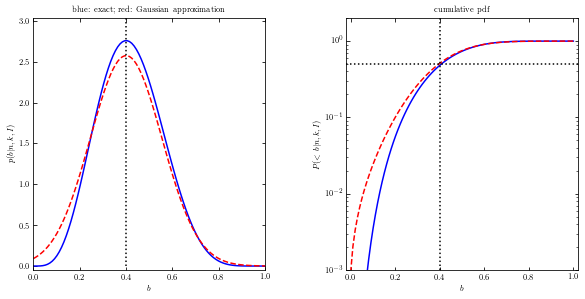

In [9]:
doBinomial(10, 4)

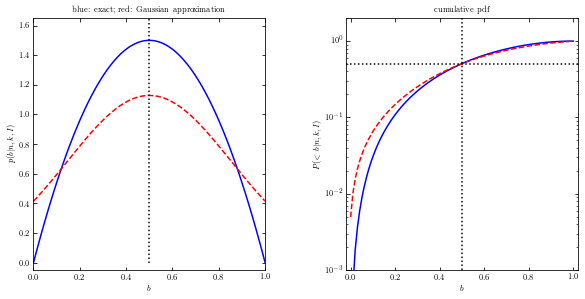

In [10]:
doBinomial(2, 1)

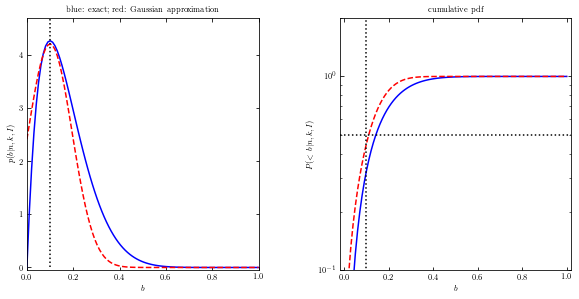

In [11]:
doBinomial(10, 1, 0.1)

## Conceptual difficulties with the MLE  <a id='ML6'></a>
[Go to top](#toc)


#### An example of a difficulty with the MLE : "waiting for a bus" problem
 
Imagine you arrive at a bus stop, and observe that the bus arrives $t$ minutes later 
(it is assumed that you had no knowledge about the bus schedule). What is the mean time 
between two successive buses, $\tau$, if the buses keep a regular schedule? 

It is easy to derive an intuitive answer. The wait time is distributed uniformly in the interval $0 \le t \le \tau$, and on average you would wait for $t=\tau/2$ minutes.  Rearranging this gives $\tau = 2t$, which agrees with intuition.

What does the maximum likelihood approach give? 

The probability that you will wait $t$ 
minutes (the likelihood of data) is given by the uniform distribution (every $t$ is equally likely)
$$ p(t\,|\,\tau) =  1/\tau, $$
if $0 \le t \le \tau$ and $p(t|\tau)=0$ otherwise.


Because we only observe a single point, the data likelihood is simply equal to this probability. 
The maximum likelihood, then, corresponds to the smallest possible $\tau$ such that $t \le \tau$: 
this is satisfied by $\tau = t$ and not $\tau=2t$ as we expected!!

Computing the expectation value or the median for $\tau$ does not help either because
the resulting integrals diverge. These puzzling results are resolved by the use of appropriate prior
information, as will be discussed in a moment. We shall see several other examples later where the
addition of extra information changes the results we would get from the maximum likelihood
approach.

The Bayesian method is not, however, motivated by the differences in results
between maximum likelihood and Bayesian techniques.  These differences are
often negligible, especially when the data sets are large.  Rather, **the Bayesian
method is motivated by its ability to provide a full probabilistic framework
for data analysis**. One of the most important aspects of Bayesian analysis is the 
ability to straightforwardly incorporate unknown or uninteresting model 
parameters, the so-called nuisance parameters, in data analysis. 

### For completeness: Bayesian solution to "bus arrival problem" (we will revisit this topic later)
 

In our **bus arrival problem**, $\tau$ is unknown model parameter and data (datum) is $t$. The
posterior pdf for $\tau$ is (we ignore normalization): 
$$p(\tau\,|\,t, I) \propto p(t\,|\,\tau,I) \, p(\tau\,|\,I).$$

The likelihood of data is given by the uniform distribution (every $t$ is equally likely, with 
$0 \le t \le \tau$):
$$ p(t\,|\,\tau,I) =  1/\tau. $$  

Following the Principle of Invariance, we assign the prior
$$ p(\tau\,|\,I) = 1/ \tau.$$

Note: the two pdfs look the same but this is essentially a coincidence. 

So, we have 
    $$p(\tau \,|\, t,I) \propto  \frac{1}{\tau^2},$$
for $\tau > t$ and 0 otherwise. We use normalization constraint 
$$ \int_t^\infty p(\tau\,|\,I)d\tau = \int_t^\infty \frac{C}{\tau^2} d\tau \equiv 1,$$
to get $C=t$ (the divergent integral over $\tau$ encountered in the maximum likelihood 
analysis is mitigated here by the extra $\tau$ term from the prior).

The properly normalized posterior pdf for $\tau$ (valid for $\tau > t$) is thus 
$$   p(\tau \,|\, t,I) = \frac{t}{\tau^2}.$$
  
  
The median $\tau$ given by the posterior $p(\tau \,|\, t,I)$ is now equal to $2t$, 
in agreement with our expectations. 

An interesting side result is that the p% quantiles 
are equal to ($1-t/\tau$); for example, the 95% confidence region for $\tau$, 
or **the credible region**, spans $1.03 t < \tau < 40 t$. If we waited for a bus 
for just 1 minute, then, adopting the usual 95% confidence region, we cannot reject the 
possibility that $\tau$ is as large as 40 minutes. 

Equivalently, if we waited for a 
bus for 1 minute, we can paraphrase Laplace and say that “it is a bet of 20 against 1 
that **the bus will arrive in the interval between 0.03 minutes and 39 minutes from now**.”





## What if we cannot write down the likelihood function?  <a id='ML7'></a>
[Go to top](#toc)

Sometimes you need to think harder. If no success, one can use methods
such as **Approximate Bayesian Computation** (ABC).  ABC is essentially a
rejection algorithm that only "accepts" model parameter values (drawn
from prior) for which some judiciously chosen "summary statistic" is 
"close enough" to its value computed from data. 

We don't have time to discuss ABC in depth, but you can look it up on Wikipedia! 

https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

In addition, here is a 
[practical ABC example from astroML](https://www.astroml.org/book_figures/chapter5/fig_ABCexample.html)
or [notebook version](https://www.astroml.org/astroML-notebooks/chapter5/astroml_chapter5_Approximate_Bayesian_Computation.html)


 

### What did we learn today? 

1. Likelihood function plays a central role in both frequentist and Bayesian
data analysis - it encapsulates our knowledge (beliefs) about the data generation process

2. In frequentist framework, likelihood is only one of possible cost functions; in Bayesian
   framework, it plays a major role. 

3. Maximum likelihood method provides theoretical foundations for many common results
(e.g. weighted mean) and enables fitting of complex functions to data.

4. For normal (gaussian) distribution, MLE method becomes $\chi^2$ minimization. 

5. **Likelihood doesn't have to be gaussian** - indeed, sometimes it's impossible to 
write it down!

6. ML method, while exceedingly useful, can sometimes produce counter-intuitive results - Bayes to the rescue! 




[Go to top](#toc)